In [1]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
#from transformers import get_linear_schedule_with_warmup

import time
import datetime

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import matthews_corrcoef

from transformers import BertForSequenceClassification, AdamW, BertConfig

C:\Users\lovew\.conda\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## 1. Подготовка данных

In [4]:
df_train = pd.read_csv("./in_domain_train.csv")
df_train.head()

,id,sentence,acceptable,error_type,detailed_source
0,0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010


In [5]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))

Number of training sentences: 7,869



In [5]:
df_dev = pd.read_csv("./in_domain_dev.csv")
df_dev.head()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\lovew\AppData\Local\Temp\ipykernel_29752\4921259.py:1: SyntaxWarning: invalid escape sequence '\i'
  df_dev = pd.read_csv("d:\\Learning\\Otus\\ML_Professional\\exercises\\27_hw\\data\in_domain_dev.csv")


,id,sentence,acceptable,error_type,detailed_source
0,0,Иван вчера не позвонил.,1,0,Paducheva2013
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets


In [7]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_dev.shape[0]))

Number of training sentences: 983



## 2.Вспомогательные функции

Получение токенов, id и label в предложениях

In [6]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def get_Tokens_IDs(model_tokenizer, sentences, labels):
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
    # `encode_plus` will:
    #   (1) Разобьет предложения на токены.
    #   (2) Добавит специальные токены [CLS] и [SEP].
    #   (3) аменит токены на их ID..
    #   (4) Приведет все предложения к одной длине - max_len`
    #   (5) Создаст attention masks для [PAD] токенов.
      encoded_dict = model_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])
  return input_ids, attention_masks, labels

Делит данные на тестовые и валидационные

In [7]:

def get_train_test_dataset(input_ids, attention_masks, labels):
  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10 train-validation split.

# Calculate the number of samples to include in each set.
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))
  return train_dataset, val_dataset

#### Вспомогательная функция для отслеживания затраченного времени

In [8]:
# Вспомогательная функция для отслеживания затраченного времени
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### функция обучения

In [9]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

def training(model, scheduler, optimizer, epochs_ts, train_dataloader_ts, validation_dataloader_ts):
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
    training_stats = []

# Measure the total training time for the whole run.
    total_t0 = time.time()

# For each epoch...
    for epoch_i in range(0, epochs_ts):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs_ts))
        print('Training...')

    # Measure how long the training epoch takes.
        t0 = time.time()

    # Reset the total loss for this epoch.
        total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

    # For each batch of training data...
        for step, batch in enumerate(train_dataloader_ts):

        # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

            # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_ts), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
            res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
            loss = res['loss']
            logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
            total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
            loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
            optimizer.step()

        # Update the learning rate.
            scheduler.step()

    # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader_ts)

    # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
        model.eval()

    # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

    # Evaluate data for one epoch
        for batch in validation_dataloader_ts:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
                res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = res['loss']
            logits = res['logits']

        # Accumulate the validation loss.
            total_eval_loss += loss.item()

        # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_ts)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader_ts)

    # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
        training_stats.append(
            {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

### Loss

In [10]:
def draw_loss(df_stats):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show()

### Оценка

In [11]:
# Prediction on test set
def precision(model, prediction_dataloader, input_ids_ts):
    print('Predicting labels for {:,} test sentences...'.format(len(input_ids_ts)))

# Put model in evaluation mode
    model.eval()

# Tracking variables
    predictions , true_labels = [], []

# Predict
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)

      logits = outputs[0]

  # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

    print('    DONE.')
    return logits, true_labels, predictions

In [12]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## 3. Модель RuBert(ruBert-base)

In [15]:
from transformers import BertTokenizer

In [16]:
# Get the lists of sentences and their labels.
sentences = df_train.sentence.values
labels = df_train.acceptable.values

**3.1. Токенизация данных**

In [17]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
#tokenizer_rubert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer_rubert = BertTokenizer.from_pretrained('ai-forever/ruBert-base')

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

In [24]:
input_ids_rubert, attention_masks_rubert, labels_rubert = get_Tokens_IDs(tokenizer_rubert, sentences, labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([   101,   3014,  83321,  41548,  32350,    113,   2931,    121,    107,
           660,  50354,  13779,  99183,  15226,    121,  94376,  19913,    700,
         55918,   6412,    121,    107,  95640,    377, 104691,    717,  11420,
           126,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


**3.2. Делим данные на train и valid**

In [26]:
train_dataset_rubert, val_dataset_rubert = get_train_test_dataset(input_ids_rubert, attention_masks_rubert, labels_rubert)

6,295 training samples
1,574 validation samples


**3.3. Создаем dataloader**

In [28]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader_rubert = DataLoader(
            train_dataset_rubert,  # The training samples.
            sampler = RandomSampler(train_dataset_rubert), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader_rubert = DataLoader(
            val_dataset_rubert, # The validation samples.
            sampler = SequentialSampler(val_dataset_rubert), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

**3.4. Модель**

In [29]:
model_rubert = BertForSequenceClassification.from_pretrained('ai-forever/ruBert-base', num_labels=2).to("cuda")

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:


# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "ai-forever/ruBert-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model_rubert.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## 3.1. Оптимизатор

In [31]:
optimizer_rubert = AdamW(model_rubert.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 3.2 Обучение

In [32]:
from transformers import get_linear_schedule_with_warmup

In [33]:
# задаем начальные установки для запуска обучения
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps_rubert = len(train_dataloader_rubert) * epochs

# Create the learning rate scheduler.
scheduler_rubert = get_linear_schedule_with_warmup(optimizer_rubert,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps_rubert)

In [34]:
import random
import numpy as np

In [35]:
# запуск обучения
training_stats_rubert = training(model_rubert, scheduler_rubert, optimizer_rubert, epochs, train_dataloader_rubert, validation_dataloader_rubert)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:00:16.
  Batch    80  of    197.    Elapsed: 0:00:29.
  Batch   120  of    197.    Elapsed: 0:00:43.
  Batch   160  of    197.    Elapsed: 0:00:58.

  Average training loss: 0.54
  Training epcoh took: 0:01:11

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.48
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:00:14.
  Batch    80  of    197.    Elapsed: 0:00:29.
  Batch   120  of    197.    Elapsed: 0:00:43.
  Batch   160  of    197.    Elapsed: 0:00:57.

  Average training loss: 0.40
  Training epcoh took: 0:01:10

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.49
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:00:14.
  Batch    80  of    197.    Elapsed: 0:00:29.
  Batch   120  of    197.    Elapsed: 0:00:43.
  Batch   160  of    197.    Elapsed: 0:00:57.



###  3.2.1. Cаммари обучающего процесса!

In [36]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_training_stats_rubert = pd.DataFrame(data=training_stats_rubert)

# Use the 'epoch' as the row index.
df_training_stats_rubert = df_training_stats_rubert.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_training_stats_rubert

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.540287,0.482317,0.796667,0:01:11,0:00:06
2,0.400580,0.485050,0.798542,0:01:10,0:00:05
3,0.235875,0.596347,0.803542,0:01:10,0:00:05
4,0.153165,0.672444,0.799167,0:01:10,0:00:05


### 3.2.2. Loss на валидации

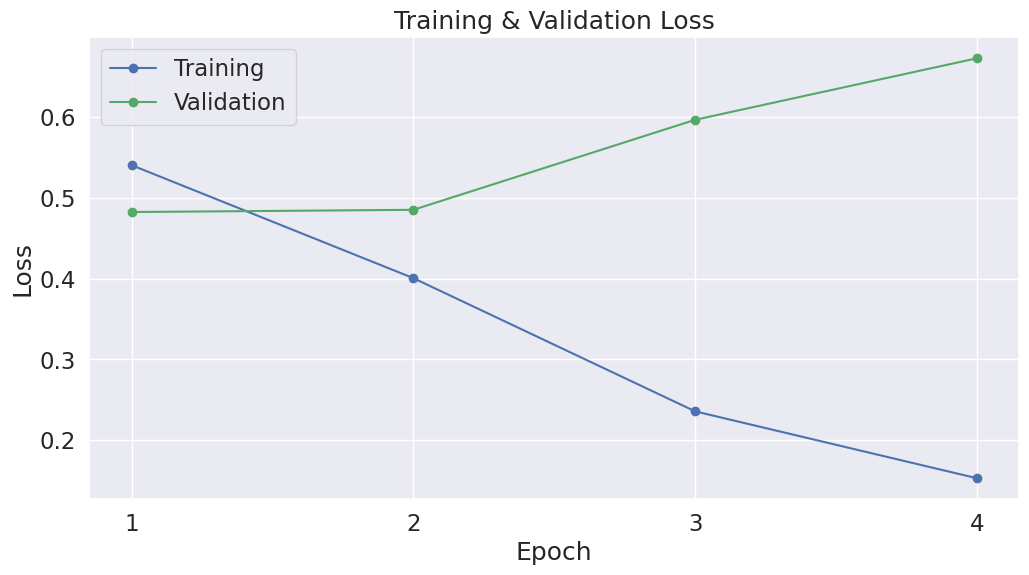

In [37]:
draw_loss(df_training_stats_rubert)

## 3.3. Тестирование

### 3.3.1. Создаем тестовые данные + DataLoader для них

In [38]:
# Create sentence and label lists
sentences_test = df_dev.sentence.values
labels_test = df_dev.acceptable.values

In [39]:

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_test_ids = []
attention_test_masks = []

# For every sentence...
for sent in sentences_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer_rubert.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_test_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_test_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_test_ids = torch.cat(input_test_ids, dim=0)
attention_test_masks = torch.cat(attention_test_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.
batch_size_test = 32

# Create the DataLoader.
prediction_test_data = TensorDataset(input_test_ids, attention_test_masks, labels_test)
prediction_test_sampler = SequentialSampler(prediction_test_data)
prediction_test_dataloader = DataLoader(prediction_test_data, sampler=prediction_test_sampler, batch_size=batch_size_test)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 3.3.2. Тестирование и оценка

In [40]:
eval_rubert = precision(model_rubert, prediction_test_dataloader, input_test_ids)
logits_rubert = eval_rubert[0]
true_labels_rubert = eval_rubert[1]
predictions_rubert = eval_rubert[2]

Predicting labels for 983 test sentences...
    DONE.


In [41]:
print('Positive samples: %d of %d (%.2f%%)' % (df_dev.acceptable.sum(), len(df_dev.acceptable), (df_dev.acceptable.sum() / len(df_dev.acceptable) * 100.0)))

Positive samples: 733 of 983 (74.57%)


####  Коэффициент корреляции Мэтьюса

In [42]:
matthews_rubert_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels_rubert)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_rubert_i = np.argmax(predictions_rubert[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels_rubert[i], pred_labels_rubert_i)
  matthews_rubert_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


#### Финальный скор считается по всему датасету. Объединим результаты и получим общий MCC скор.

In [43]:
# Combine the results across all batches.
flat_rubert_predictions = np.concatenate(predictions_rubert, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_rubert_predictions = np.argmax(flat_rubert_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_rubert_labels = np.concatenate(true_labels_rubert, axis=0)

# Calculate the MCC
mcc_rubert = matthews_corrcoef(flat_true_rubert_labels, flat_rubert_predictions)

print('Общее MCC: %.3f' % mcc_rubert)

Общее MCC: 0.353


## 4. Модель RuRoBerta()

In [44]:
model_ruroberta = BertForSequenceClassification.from_pretrained('ai-forever/ruRoberta-large', num_labels=2).to("cuda")

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.Lay

In [46]:
from transformers import RobertaTokenizer

In [47]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
#tokenizer_rubert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer_ruroberta = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

Loading BERT tokenizer...


vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

In [48]:
input_ruroberta_ids, attention_ruroberta_masks, labels_ruroberta = get_Tokens_IDs(tokenizer_ruroberta, sentences, labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([    1, 18875, 17040,   428, 22701, 22971,   281,  1942,    16,   289,
          324, 39275, 12197,  7912,  4575, 10506,    16, 10891, 12805,   328,
          362, 10237,   458,  4770,    16,   289, 39443,   487, 33338,  6615,
           18,     2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## 4.3. Делим на тестовые и валидационные данные

In [49]:
train_ruroberta_dataset, val_ruroberta_dataset = get_train_test_dataset(input_ruroberta_ids, attention_ruroberta_masks, labels_ruroberta)

6,295 training samples
1,574 validation samples


## 4.4. Создаем DataLoader

In [50]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_ruroberta_dataloader = DataLoader(
            train_ruroberta_dataset,  # The training samples.
            sampler = RandomSampler(train_ruroberta_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_ruroberta_dataloader = DataLoader(
            val_ruroberta_dataset, # The validation samples.
            sampler = SequentialSampler(val_ruroberta_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 4.1. Оптимизатор

In [52]:
optimizer_ruroberta = AdamW(model_ruroberta.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [53]:
model_ruroberta.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

## 4.2 Обучение

In [54]:
# задаем начальные установки для запуска обучения
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs_ruroberta = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps_ruroberta = len(train_ruroberta_dataloader) * epochs_ruroberta

# Create the learning rate scheduler.
scheduler_ruroberta = get_linear_schedule_with_warmup(optimizer_ruroberta,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps_ruroberta)

In [55]:
#set CUDA_LAUNCH_BLOCKING = 1
#set TORCH_USE_CUDA_DSA = 1# запуск обучения
testing_ruroberta_stats = training(model_ruroberta, scheduler_ruroberta, optimizer_ruroberta, epochs_ruroberta, train_ruroberta_dataloader, validation_ruroberta_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:00:46.
  Batch    80  of    197.    Elapsed: 0:01:30.
  Batch   120  of    197.    Elapsed: 0:02:15.
  Batch   160  of    197.    Elapsed: 0:03:00.

  Average training loss: 0.59
  Training epcoh took: 0:03:41

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.59
  Validation took: 0:00:18

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:00:45.
  Batch    80  of    197.    Elapsed: 0:01:30.
  Batch   120  of    197.    Elapsed: 0:02:14.
  Batch   160  of    197.    Elapsed: 0:02:59.

  Average training loss: 0.58
  Training epcoh took: 0:03:40

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.58
  Validation took: 0:00:18

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    197.    Elapsed: 0:00:45.
  Batch    80  of    197.    Elapsed: 0:01:30.
  Batch   120  of    197.    Elapsed: 0:02:14.
  Batch   160  of    197.    Elapsed: 0:02:59.



In [57]:
training_ruroberta_stats = testing_ruroberta_stats

###  4.2.1. Cаммари обучающего процесса!

In [58]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_training_ruroberta_stats = pd.DataFrame(data=training_ruroberta_stats)

# Use the 'epoch' as the row index.
df_training_ruroberta_stats = df_training_ruroberta_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_training_ruroberta_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.592822,0.585026,0.729375,0:03:41,0:00:18
2,0.576257,0.583394,0.729375,0:03:40,0:00:18
3,0.580093,0.592168,0.729375,0:03:40,0:00:18
4,0.568776,0.584419,0.729375,0:03:40,0:00:18


### 4.2.2. Loss на валидации

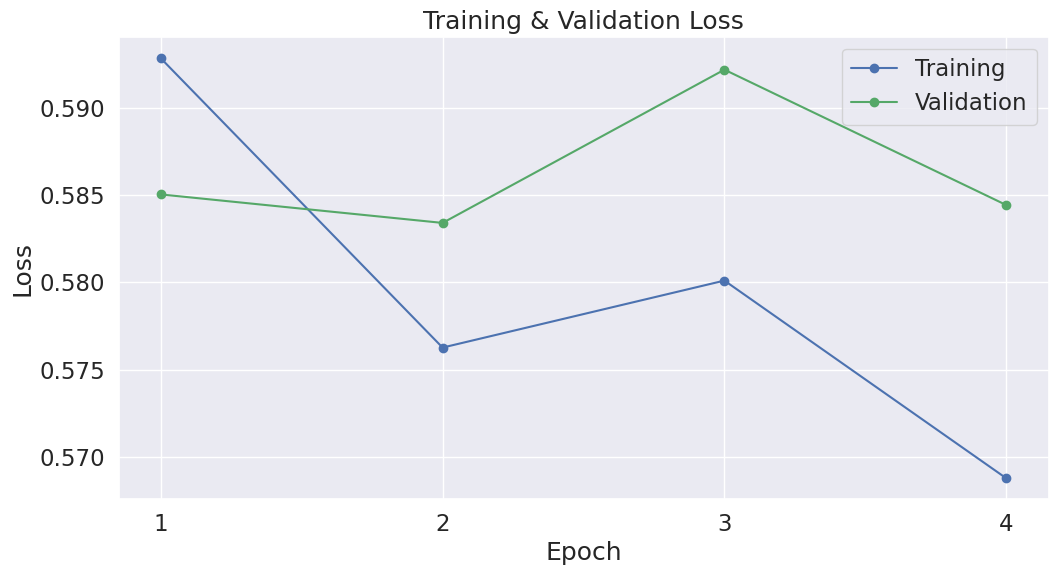

In [59]:
draw_loss(df_training_ruroberta_stats)

## 4.3. Тестирование

4.3.1. Создаем тестовые данные + DataLoader для них

In [60]:
# Create sentence and label lists
sentences_ruroberta_test = df_dev.sentence.values
labels_ruroberta_test = df_dev.acceptable.values

In [61]:

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_test_ruroberta_ids = []
attention_test_ruroberta_masks = []

# For every sentence...
for sent in sentences_ruroberta_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer_ruroberta.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_test_ruroberta_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_test_ruroberta_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_test_ruroberta_ids = torch.cat(input_test_ruroberta_ids, dim=0)
attention_test_ruroberta_masks = torch.cat(attention_test_ruroberta_masks, dim=0)
labels_ruroberta_test = torch.tensor(labels_ruroberta_test)

# Set the batch size.
batch_size_test = 32

# Create the DataLoader.
prediction_test_ruroberta_data = TensorDataset(input_test_ruroberta_ids, attention_test_ruroberta_masks, labels_ruroberta_test)
prediction_test_ruroberta_sampler = SequentialSampler(prediction_test_ruroberta_data)
prediction_test_ruroberta_dataloader = DataLoader(prediction_test_ruroberta_data, sampler=prediction_test_ruroberta_sampler, batch_size=batch_size_test)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 4.3.2. Тестирование и оценка

In [62]:
eval_ruroberta_test = precision(model_ruroberta, prediction_test_ruroberta_dataloader, input_test_ruroberta_ids)
logits_ruroberta_test = eval_ruroberta_test[0]
true_labels_ruroberta_test = eval_ruroberta_test[1]
predictions_ruroberta_test = eval_ruroberta_test[2]

Predicting labels for 983 test sentences...
    DONE.


In [63]:
print('Positive samples: %d of %d (%.2f%%)' % (df_dev.acceptable.sum(), len(df_dev.acceptable), (df_dev.acceptable.sum() / len(df_dev.acceptable) * 100.0)))

Positive samples: 733 of 983 (74.57%)


####  Коэффициент корреляции Мэтьюса

In [64]:
matthews_ruroberta_test_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels_ruroberta_test)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_ruroberta_test_i = np.argmax(predictions_ruroberta_test[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews_ruroberta_test = matthews_corrcoef(true_labels_ruroberta_test[i], pred_labels_ruroberta_test_i)
  matthews_ruroberta_test_set.append(matthews_ruroberta_test)

Calculating Matthews Corr. Coef. for each batch...


#### Финальный скор считается по всему датасету. Объединим результаты и получим общий MCC скор.

In [65]:
# Combine the results across all batches.
flat_rurobert_test_predictions = np.concatenate(predictions_ruroberta_test, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_ruroberta_test_predictions = np.argmax(flat_rurobert_test_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_ruroberta_test_labels = np.concatenate(true_labels_ruroberta_test, axis=0)

# Calculate the MCC
mcc_ruroberta_test = matthews_corrcoef(flat_true_ruroberta_test_labels, flat_ruroberta_test_predictions)

print('Общее MCC: %.3f' % mcc_ruroberta_test)

Общее MCC: 0.000


**6.RuGPT3 large**

In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
#from transformers import get_linear_schedule_with_warmup

import time
import datetime

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import matthews_corrcoef

from transformers import BertForSequenceClassification, AdamW, BertConfig

In [ ]:
df_dev = pd.read_csv("./in_domain_dev.csv")
df_dev.head()

,id,sentence,acceptable,error_type,detailed_source
0,0,Иван вчера не позвонил.,1,0,Paducheva2013
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
device

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


device(type='cuda')

**6.1. Модель**

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_rugpt3 = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")

model_rugpt3 = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")


**6.2. Метод Zero-shot**

In [19]:
import math
def calc_loss(phrase: str,
                        tokenizer,
                        model):

    phrase = tokenizer.encode(phrase)
    # Если длина фразы 1 токен, то дальше ошибка вылезет :(
    if len(phrase) == 1:
         phrase.append(tokenizer.eos_token_id)
    phrase = torch.tensor(phrase, dtype=torch.long, device=device)
    phrase = phrase.unsqueeze(0)  # .repeat(num_samples, 1)
    with torch.no_grad():
        loss = model(phrase, labels=phrase)

    loss[0].item()


    return loss[0].item()

def get_loss_num(text):
    loss = calc_loss(phrase=text, model=model_rugpt3, tokenizer=tokenizer_rugpt3)
    return loss

def clean(text):
    text = re.sub(r'\((\d+)\)', '', text)
    return text

In [20]:
def predict_zero_shot(text):
  pos_loss = get_loss_num('Позитивный твит: ' + text + ')))')
  neg_loss = get_loss_num('Негативный твит: ' + text + '(((')
  if pos_loss < neg_loss:
    return 0
  return 1



In [21]:
train_prev_size = int(0.8 * len(df_train))
val_prev_size = len(df_train) - train_prev_size

In [22]:
df_train_new = df_train.loc[0:train_prev_size];
len(df_train_new)

6296

In [23]:
from sklearn.metrics import accuracy_score


df_train_new['preds'] = df_train_new.sentence.apply(predict_zero_shot)
accuracy_score(df_train_new.acceptable, df_train_new.preds)

C:\Users\lovew\AppData\Local\Temp\ipykernel_29752\112409902.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_new['preds'] = df_train_new.sentence.apply(predict_zero_shot)


0.2625476493011436

accuracy = 0.2625476493011436

In [24]:
df_train_new.tail()

,id,sentence,acceptable,error_type,detailed_source,preds
6291,6291,"Как говорит Аристотель, человек обладает свобо...",1,0,Paducheva2010,0
6292,6292,Тут перед глазами Римского возник циферблат ег...,1,0,Paducheva2004,0
6293,6293,Мальчик выглядывает из окна.,1,0,Paducheva2004,0
6294,6294,"Мария считает, что какой-то крокодил пугает ее...",1,0,Paducheva2010,0
6295,6295,Коллеги собирались арендовать клуб для проведе...,1,0,Testelets,0


In [25]:
mcc_zero_shot = matthews_corrcoef(df_train_new.acceptable,   df_train_new.preds)

print('Общее MCC: %.3f' % mcc_zero_shot)

Общее MCC: -0.018


**6.3. Few-short**

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
df_dev_pred = df_dev.copy()

**6.3.1. Определяем 4 затравки**

In [ ]:
few_short_0 = "'Проверить текст на правописание': Текст 1:«"
few_short_1 = "'Проверить текст на правописание': Текст 1:«Вова не выехал домой» Оценка: 0 \n Текст 2:«"
few_short_2 = "'Проверить текст на правописание': Текст 1:«Вова не выехал домой» Оценка: 0 \n Текст 2:«Маша куплла холодильник» Оценка: 1 \n Текст 3: «";
few_short_4 = "'Проверить текст на правописание': Текст 1:«Вова не выехал домой» Оценка: 1 \n Текст 2:«Маша куплла холодильник» Оценка: 0 \n Текст 3: «Самка слми ручку» Оценка: 0 \n Текст 4: «Леня поймал удочкой рыбу» Оценка: 1 \n Текст 5: « "

In [ ]:
prefix_end = "» "
prefix_text = " Оценка: "

In [ ]:
## ф-я для обработки результат - считываем оценку сгенерированного текста моделью
def get_result_labels(senteces_result):
  #result_labels = []

  ind_find = senteces_result.rfind(prefix_text);
  ind_find = ind_find + len(prefix_text)
  sub_result = senteces_result[ind_find: ind_find + 3]
  for result_score in filter( str.isdigit , sub_result):
    return int(result_score);

In [ ]:
## ф-я для обработки моделью текста на провописание, на выходе получаем оценку 1(принято) или 0 (не принято)
def handle_text(curr_sentences):
  inpt = tokenizer_rugpt3.encode(few_short + curr_sentences+ prefix_end + prefix_text, return_tensors="pt")
  out = model_rugpt3.generate(inpt, repetition_penalty=2.0, temperature=0.7)
  response = get_result_labels(tokenizer_rugpt3.decode(out[0]));
  return response;

**6.3.2. Затравки**

**6.3.2.1. Затравка few-shot, примеров 0**

In [ ]:
few_short = few_short_0
df_dev_pred['preds_0'] = df_dev_pred.sentence.apply(handle_text)

C:\Users\lovew\.conda\envs\pytorch-env\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
df_dev_pred.head()

,id,sentence,acceptable,error_type,detailed_source,preds_0
0,0,Иван вчера не позвонил.,1,0,Paducheva2013,5.0
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8,2.0
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5,5.0
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova,NaN
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets,5.0


In [ ]:
# нормализуем оценки от 5-ти бальной к бинарной
df_dev_pred['preds_0'] = df_dev_pred['preds_0'].map(lambda x: 1 if x == 5.0 else 0)

**6.3.2.1.1. Оценка**

In [ ]:
acc_score_few_shot_0 = accuracy_score(df_dev_pred.acceptable, df_dev_pred.preds_0)
print('Общее accuracy: %.3f' % acc_score_few_shot_0)

Общее accuracy: 0.591


In [ ]:
mcc_few_shot_1 = matthews_corrcoef(df_dev_pred.acceptable,  df_dev_pred.preds_0)

print('Общее MCC: %.3f' % mcc_few_shot_1)

Общее MCC: 0.083


**6.3.2.2. Затравка few-shot, примеров 1.**

In [ ]:
few_short = few_short_1
df_dev_pred['preds_1'] = df_dev_pred.sentence.apply(handle_text)

C:\Users\lovew\.conda\envs\pytorch-env\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
df_dev_pred.head()

,id,sentence,acceptable,error_type,detailed_source,preds_0,preds_1
0,0,Иван вчера не позвонил.,1,0,Paducheva2013,1,0.0
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8,0,0.0
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5,1,0.0
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova,0,0.0
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets,1,0.0


In [ ]:
df_dev_pred.preds_1.isnull().sum()

6

In [ ]:
df_dev_pred["preds_1"].fillna(0, inplace = True)

In [ ]:
df_dev_pred.preds_1.isnull().sum()

0

**6.3.2.2.1. Оценка**

In [ ]:
acc_score_few_shot_1 = accuracy_score(df_dev_pred.acceptable, df_dev_pred.preds_1)
print('Общее accuracy: %.3f' % acc_score_few_shot_1)

Общее accuracy: 0.246


In [ ]:
mcc_few_shot_1 = matthews_corrcoef(df_dev_pred.acceptable,  df_dev_pred.preds_1)

print('Общее MCC: %.3f' % mcc_few_shot_1)

Общее MCC: 0.007


**6.3.2.3. Затравка few-shot, примеров 2**

In [ ]:
few_short = few_short_2
df_dev_pred['preds_2'] = df_dev_pred.sentence.apply(handle_text)

C:\Users\lovew\.conda\envs\pytorch-env\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
df_dev_pred.head()

,id,sentence,acceptable,error_type,detailed_source,preds_0,preds_1,preds_2
0,0,Иван вчера не позвонил.,1,0,Paducheva2013,1,0.0,1.0
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8,0,0.0,1.0
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5,1,0.0,1.0
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova,0,0.0,0.0
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets,1,0.0,1.0


In [ ]:
df_dev_pred.preds_2.isnull().sum()

43

In [ ]:
df_dev_pred["preds_2"].fillna(0, inplace = True)

**6.3.2.3.1. Оценка**

In [ ]:
acc_score_few_shot_2 = accuracy_score(df_dev_pred.acceptable, df_dev_pred.preds_2)
print('Общее accuracy: %.3f' % acc_score_few_shot_2)

Общее accuracy: 0.615


In [ ]:
mcc_few_shot_2 = matthews_corrcoef(df_dev_pred.acceptable,  df_dev_pred.preds_2)
print('Общее MCC: %.3f' % mcc_few_shot_2)

Общее MCC: 0.071


**6.3.2.4. Затравка few-shot, примеров 4.**

In [ ]:
few_short = few_short_4
df_dev_pred['preds_4'] = df_dev_pred.sentence.apply(handle_text)

C:\Users\lovew\.conda\envs\pytorch-env\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
df_dev_pred.preds_4.isnull().sum()

0

In [ ]:
df_dev_pred.head()

,id,sentence,acceptable,error_type,detailed_source,preds_0,preds_1,preds_2,preds_4
0,0,Иван вчера не позвонил.,1,0,Paducheva2013,1,0.0,1.0,0.0
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8,0,0.0,1.0,1.0
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5,1,0.0,1.0,1.0
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova,0,0.0,0.0,1.0
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets,1,0.0,1.0,1.0


In [ ]:
df_dev_pred["preds_4"].fillna(0.0, inplace = True)

C:\Users\lovew\AppData\Local\Temp\ipykernel_35356\3833320799.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dev_pred["preds_4"].fillna(0.0, inplace = True)


6.3.2.4.1. Оценка

In [ ]:
acc_score_few_shot_4 = accuracy_score(df_dev_pred.acceptable, df_dev_pred.preds_4)
print('Общее accuracy: %.3f' % acc_score_few_shot_4)

Общее accuracy: 0.517


In [ ]:
mcc_few_shot_4 = matthews_corrcoef(df_dev_pred.acceptable,  df_dev_pred.preds_4)
print('Общее MCC: %.3f' % mcc_few_shot_4)

Общее MCC: -0.108


**END**

**7. RuT5**

In [ ]:
!pip install datasets

   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   - -------------------------------------- 1.0/25.1 MB 5.6 MB/s eta 0:00:05
   --- ------------------------------------ 2.1/25.1 MB 5.3 MB/s eta 0:00:05
   ----- ---------------------------------- 3.1/25.1 MB 5.6 MB/s eta 0:00:04
   ------- -------------------------------- 4.5/25.1 MB 5.6 MB/s eta 0:00:04
   --------- ------------------------------ 5.8/25.1 MB 5.8 MB/s eta 0:00:04
   ----------- ---------------------------- 7.3/25.1 MB 6.0 MB/s eta 0:00:03
   ------------ --------------------------- 8.1/25.1 MB 5.8 MB/s eta 0:00:03
   -------------- ------------------------- 8.9/25.1 MB 5.5 MB/s eta 0:00:03
   --------------- ------------------------ 9.7/25.1 MB 5.3 MB/s eta 0:00:03
   ---------------- ----------------------- 10.2/25.1 MB 5.2 MB/s eta 0:00:03
   ----------------- ---------------------- 10.7/25.1 MB 4.9 MB/s eta 0:00:03
   ----------------- ---------------------- 11.3/25.1 MB 4.7 MB/s eta 0:00:03
   

In [ ]:
!pip install SentencePiece

   ---------------------------------------- 0.0/992.0 kB ? eta -:--:--
   ------------------------------- -------- 786.4/992.0 kB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 992.0/992.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install razdel

In [1]:
import os
from argparse import ArgumentParser
from functools import partial
#from shutil import rmtree

import numpy as np
#from datasets import load_metric
from razdel import tokenize
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    T5Tokenizer,
    T5ForConditionalGeneration,
)

#from utils import read_splits

C:\Users\lovew\.conda\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path

import pandas as pd
from datasets import Dataset, DatasetDict


TRAIN_FILE = "d:\\Learning\\Otus\\ML_Professional\\exercises\\27_hw\\data\\in_domain_train.csv"
IN_DOMAIN_DEV_FILE = "d:\\Learning\\Otus\\ML_Professional\\exercises\\27_hw\\data\\in_domain_dev.csv"


def read_splits(*, as_datasets):
    train_df, in_domain_dev_df = map(
        pd.read_csv, (TRAIN_FILE, IN_DOMAIN_DEV_FILE)
    )
    #print("read file")

    if as_datasets:
        train, dev = map(Dataset.from_pandas, (train_df, in_domain_dev_df))
        return DatasetDict(train=train, dev=dev)
    else:
        return train_df, in_domain_dev_df

In [3]:
def getmattews_coeff(true_labels_test, predictions):

  matthews_set = []

  # Evaluate each test batch using Matthew's correlation coefficient
  print('Calculating Matthews Corr. Coef. for each batch...')

  # For each input batch...
  for i in range(len(true_labels_test)):

    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    matthews = matthews_corrcoef(true_labels_test[i], pred_labels_i)
    matthews_set.append(matthews)

  return matthews_set

In [4]:
# Prediction on test set
def precision(model, prediction_dataloader, input_ids_ts):
    print('Predicting labels for {:,} test sentences...'.format(len(input_ids_ts)))

# Put model in evaluation mode
    model.eval()

# Tracking variables
    predictions , true_labels = [], []

# Predict
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)

      logits = outputs[0]

  # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

    print('    DONE.')
    return logits, true_labels, predictions

In [5]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [6]:
import warnings


warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [7]:
#ACCURACY = load_metric("accuracy", keep_in_memory=True)
#MCC = load_metric("matthews_correlation", keep_in_memory=True)
#MODEL_TO_HUB_NAME = {
#    "t5-base": "sberbank-ai/ruT5-base",
#    "t5-large": "sberbank-ai/ruT5-large",
#}

os.environ["TOKENIZERS_PARALLELISM"] = "false"

#N_SEEDS = 10
#N_EPOCHS = 20
N_SEEDS = 1
N_EPOCHS = 20
LR_VALUES = (1e-4, 1e-3)
DECAY_VALUES = (0, 1e-4)
BATCH_SIZES = (128,)

POS_LABEL = "yes"
NEG_LABEL = "no"

In [8]:
import evaluate
ACCURACY = evaluate.load("accuracy", keep_in_memory=True)
MCC = evaluate.load("matthews_correlation", keep_in_memory=True)

In [9]:
def compute_metrics(p, tokenizer):
    string_preds = tokenizer.batch_decode(p.predictions, skip_special_tokens=True)
    int_preds = [1 if prediction == POS_LABEL else 0 for prediction in string_preds]

    labels = np.where(p.label_ids != -100, p.label_ids, tokenizer.pad_token_id)
    string_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    int_labels = []

    for string_label in string_labels:
        if string_label == POS_LABEL:
            int_labels.append(1)
        elif string_label == NEG_LABEL or string_label == "":  # second case accounts for test data
            int_labels.append(0)
        else:
            raise ValueError()

  #  print("int_labels = ", len(int_labels))
  #  print("int_preds = ", len(int_preds))
    print(int_labels[0])
    print(int_preds[0])

    acc_result = ACCURACY.compute(predictions=int_preds, references=int_labels)
    mcc_result = MCC.compute(predictions=int_preds, references=int_labels)

    result = {"accuracy": acc_result["accuracy"], "mcc": mcc_result["matthews_correlation"]}

    #acc_result = flat_accuracy(int_preds, int_labels)
    #mcc_result = matthews = matthews_corrcoef(int_labels, int_preds)
    #print("compute_metrics 5")
    #result = {"accuracy": acc_result, "mcc": mcc_result}

    return result


def preprocess_examples(examples, tokenizer):
    result = tokenizer(examples["sentence"], padding=False)
    #print("pr 1")

    if "acceptable" in examples:
        label_sequences = []
        for label in examples["acceptable"]:
            if label == 1:
                target_sequence = POS_LABEL
            elif label == 0:
                target_sequence = NEG_LABEL
            else:
                raise ValueError("Unknown class label")
            label_sequences.append(target_sequence)

    else:
        # a hack to avoid the "You have to specify either decoder_input_ids or decoder_inputs_embeds" error
        # for test data
        label_sequences = ["" for _ in examples["sentence"]]

    #print("pr 2")

    result["labels"] = tokenizer(label_sequences, padding=False)["input_ids"]
    result["length"] = [len(list(tokenize(sentence))) for sentence in examples["sentence"]]
    return result


In [10]:
def execute(model_name):
    result_metrics = []
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    splits = read_splits(as_datasets=True)

    tokenized_splits = splits.map(
        partial(preprocess_examples, tokenizer=tokenizer),
        batched=True,
        remove_columns=["sentence"],
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8)
    #print(1)
    # seed, lr, wd, bs
    dev_metrics_per_run = np.empty((N_SEEDS, len(LR_VALUES), len(DECAY_VALUES), len(BATCH_SIZES), 2))
    #print(2)
    for i, learning_rate in enumerate(LR_VALUES):
        for j, weight_decay in enumerate(DECAY_VALUES):
            for k, batch_size in enumerate(BATCH_SIZES):
                for seed in range(N_SEEDS):
                    #print(4)
                    model = T5ForConditionalGeneration.from_pretrained(model_name)
                    #print(5)

                    run_base_dir = f"{model_name}_{learning_rate}_{weight_decay}_{batch_size}"
                    #print("6 run_base_dir = "+ run_base_dir)
                    training_args = Seq2SeqTrainingArguments(
                        output_dir=f"checkpoints/{run_base_dir}",
                        overwrite_output_dir=True,
                        evaluation_strategy="epoch",
                        per_device_train_batch_size=batch_size,
                        per_device_eval_batch_size=batch_size,
                        learning_rate=learning_rate,
                        weight_decay=weight_decay,
                        num_train_epochs=N_EPOCHS,
                        lr_scheduler_type="constant",
                        save_strategy="epoch",
                        save_total_limit=1,
                        seed=seed,
                        fp16=True,
                        dataloader_num_workers=4,
                        group_by_length=True,
                        report_to="none",
                        load_best_model_at_end=True,
                        metric_for_best_model="eval_mcc",
                        optim="adafactor",
                        predict_with_generate=True,
                    )
                    #print(7)
                    trainer = Seq2SeqTrainer(
                        model=model,
                        args=training_args,
                        train_dataset=tokenized_splits["train"],
                        eval_dataset=tokenized_splits["dev"],
                        compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
                        tokenizer=tokenizer,
                        data_collator=data_collator,
                    )
                    #print(8)
                    train_result = trainer.train()
                    #print(f"{run_base_dir}_{seed}")
                    #print("train", train_result.metrics)

                    #os.makedirs(f"results/{run_base_dir}_{seed}", exist_ok=True)

                    dev_predictions = trainer.predict(
                        test_dataset=tokenized_splits["dev"], metric_key_prefix="test", max_length=10
                    )
                    #print("dev", dev_predictions.metrics)
                    dev_metrics_per_run[seed, i, j, k] = (
                        dev_predictions.metrics["test_accuracy"],
                        dev_predictions.metrics["test_mcc"],
                    )
                    result_metrics.append(dev_metrics_per_run)
                    #print(9)
                    #predictions = trainer.predict(test_dataset=tokenized_splits["test"], max_length=10)

                    #string_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

                    #int_preds = [1 if prediction == POS_LABEL else 0 for prediction in string_preds]
                    #int_preds = np.asarray(int_preds)
                    #print(10)
                    #np.save(f"results/{run_base_dir}_{seed}/preds.npy", int_preds)

                    #rmtree(f"checkpoints/{run_base_dir}")

   # os.makedirs("results_agg", exist_ok=True)
   # np.save(f"results_agg/{model_name}_dev.npy", dev_metrics_per_run)
    return result_metrics

In [11]:
metrics_t5 = execute("sberbank-ai/ruT5-base")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Map: 100%|██████████| 983/983 [00:00<00:00, 5885.60 examples/s]
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.248714,0.745677,0.000000
2,No log,0.235979,0.745677,0.000000
3,No log,0.241624,0.745677,0.000000
4,No log,0.264948,0.745677,0.000000
5,No log,0.214874,0.745677,0.000000
6,No log,0.208608,0.756867,0.182157
7,No log,0.182294,0.786368,0.340037
8,No log,0.183603,0.791455,0.367397
9,0.309900,0.214020,0.789420,0.354006
10,0.309900,0.197360,0.789420,0.352266


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.248714,0.745677,0.000000
2,No log,0.235979,0.745677,0.000000
3,No log,0.241624,0.745677,0.000000
4,No log,0.264948,0.745677,0.000000
5,No log,0.214874,0.745677,0.000000
6,No log,0.208608,0.756867,0.182157
7,No log,0.182294,0.786368,0.340037
8,No log,0.183603,0.791455,0.367397
9,0.309900,0.214020,0.789420,0.354006
10,0.309900,0.197360,0.789420,0.352266


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.397226,0.745677,0.000000
2,No log,0.259228,0.745677,0.000000
3,No log,0.309340,0.745677,0.000000
4,No log,0.285941,0.745677,0.000000
5,No log,0.239793,0.745677,0.000000
6,No log,0.240184,0.745677,0.000000
7,No log,0.215566,0.745677,0.000000
8,No log,0.249250,0.745677,0.000000
9,0.369800,0.237132,0.745677,0.000000
10,0.369800,0.214613,0.729400,0.114298


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
0


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.411290,0.745677,0.000000
2,No log,0.278158,0.745677,0.000000
3,No log,0.261061,0.745677,0.000000
4,No log,0.272890,0.745677,0.000000
5,No log,0.234356,0.745677,0.000000
6,No log,0.239085,0.745677,0.000000
7,No log,0.221852,0.745677,0.000000
8,No log,0.254753,0.745677,0.000000
9,0.370800,0.263340,0.746694,0.054642
10,0.370800,0.263295,0.714140,0.077868


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

1
1


## 8. Итоги

Постарались для каждой модели установить похожие параметры обучения.

При анализе необходимо учитывать, что Loss на валидации - более надежный способ, чем accuracy, так как accuracy не зависит от типа ошибки и уверенности классификатора в ответе.
Если смотреть график сравнения loss на валидации и обучения, то можно заметить, что на обучении данный показатель падает, а на валидации растет, т.е. модель быстро переобучается
Несмотря на это accuracy на всех эпохах обучения почти не изменялось и оставалось достаточно хорошим - около 0.8

Модели:
1) RuBert(ruBert-base)
Validation Loss:  0.67
Accuracy:  0.799(0.803)

2) RuRoBerta(large)
Validation Loss: 0.58
Accuracy: 0.73

Судя по результатам нельзя сказать, что модель претерпела сильные изменения - показала примерно одни и теже цифры как в начале , так и в конце обучения
Возможно стоит подкрутить параметры

3) RuGPT3 large:

a) zero-short
accuracy = 0.2625476493011436
MCC: -0.018

b) few-shot
Общее Accuracy: 0.591
Общее MCC: 0.083

c) few-shot. Пример 1
Общее accuracy: 0.246
Общее MCC: 0.007

d) few-shot. Пример 2
Общее accuracy: 0.615
Общее MCC: 0.071

e) few-shot. Пример 4
Общее accuracy: 0.517
Общее MCC: -0.108

Не похоже, что затравки дают более качественный результат, единственное, что необходимо отметить, что accuracy повысилась.

4) RuT5
как мы видим, система хорошо обучается до 7-11 эпохи, а затем видны признаки переобучения:
растет loss на валидации

Самые лучшие показатели(11 эпоха на одной из итераций)

Validation Loss: 0.212249
Accuracy: 0.810783
MCC: 0.438064

Итог: для получения более качественной модели необходимо подбирать параметры, а также правильные затравки.
Видим, что при установленных параметрах модели быстро переобучаются.
Наилучшие показатели у модели RuT5

Возможно стоило уменьшить валидационную выборку в пользу обучающей в соотношении 10 на 90 и тогда бы оценки были выше.